# FRC with single images
**IIT 2018-01**

In this notebook I test the single image FRC with the same Nikon Confocal files that Taka gave me, with three different pinhole sizes.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom

import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.ui.frc_options as options
import supertomo.ui.plots.image as showim
import supertomo.data.io.read as read
import supertomo.ui.plots.frc as frcplots
import supertomo.processing.image as imops
import supertomo.analysis.resolution.analysis as fsc_analysis


from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection

import warnings
warnings.filterwarnings("ignore", message="Polyfit may be poorly conditioned")

data_dir = os.path.join(os.getcwd(), "data/2018_01_29_FRC_Nikon_Taka")
args_list = [data_dir, '--bin-delta=2', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=half-bit']

args = options.get_frc_script_options(args_list)

print args

Namespace(d_angle=20, d_bin=2.0, d_extract_angle=5.0, debug=False, directory='/Users/sami/Programming/GIT/supertomo2/notebooks/data/2018_01_29_FRC_Nikon_Taka', frc_curve_fit_degree=4, hanning=False, hollow_iterator=False, min_filter=False, normalize_power=False, pathout=None, resol_square=False, resolution_point_sigma=0.01, resolution_threshold_criterion='half-bit', resolution_threshold_curve_fit_degree=3, resolution_threshold_value=0.5, use_splines=False)


## Run FRC 

There are three image pairs in the dataset Taka gave me, each named with a pattern *filename_pinholesize.nd2* / *filename_pinholesize_.nd2*. Therefore it's rather easy to load them automatically for batch processing. Let's run the FRC for every image pair and save the results to FourierCorrelationDataCollection() which is the internal data format for storing FRC data.

In [2]:
from math import sqrt 

# Get sorted list of filenames
files = sorted([f for f in os.listdir(args.directory) if f.endswith(".nd2")])
assert len(files) % 2 == 0

data = FourierCorrelationDataCollection()
spacing = None

# Calculate FRC for every image pair
for idx in range(len(files)/2):
    image_name = files[idx*2+1]   
    image_path = os.path.join(args.directory, image_name)
    
    image1, image2 = imops.checkerboard_split(read.get_image(image_path))
    spacing = image1.spacing
    frc_task = frc.FRC(image1, image2, args.d_bin)
    data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, spacing[0], args)
results = analyzer.execute()

Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 30


## Plot results

Use Fourier Data Plotter to plot the FRC curves.

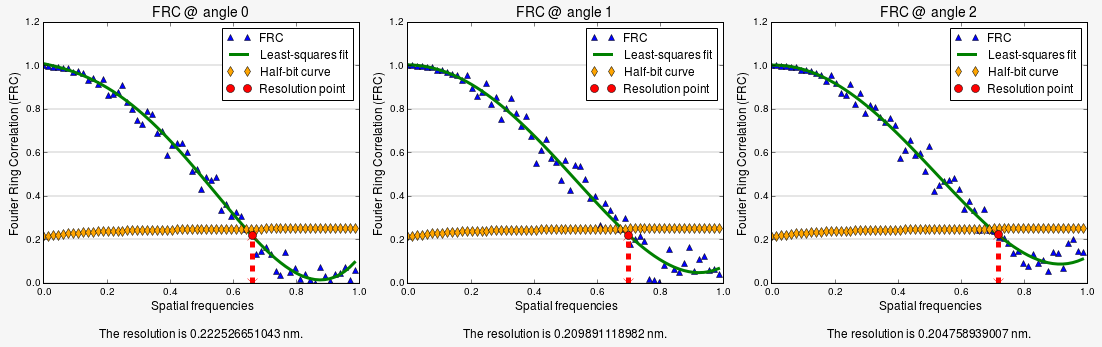

In [3]:
plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

The angle values here translate to pinhole sizes as follows: 

- 0 -> 0.4AU
- 1 -> 1.2AU
- 2 -> 2.0AU

I use minimum filtering to minimize the effects of the saturation bumps at the tail end of the FRC curves. Also the curve fit is weighted with the amount of correlation.  There's still oscilallation, but at least the decay part follows the data quite nicely. 